# Replication notebook - UrbanSim maps

Sam Maurer, December 2017, Python 3.6

In [2]:
%matplotlib inline
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandana as pdna
import pandas as pd

## Load building data from Bay Area UrbanSim

In [3]:
# Load observed home prices from Bay Area UrbanSim
path = '/Users/smmaurer/Dropbox/Data/MTC/UrbanSim/2015_09_01_bayarea_v3.h5'
store = pd.HDFStore(path)
print(store.keys())

['/buildings', '/households', '/jobs', '/jobs_urbansim_allocated', '/parcels', '/zones']


In [4]:
parcels = pd.read_hdf(store, 'parcels')
print(len(parcels))
print(parcels.columns.tolist())

1956212
['development_type_id', 'land_value', 'acres', 'county_id', 'zone_id', 'proportion_undevelopable', 'tax_exempt_status', 'apn', 'parcel_id_local', 'geom_id', 'imputation_flag', 'x', 'y', 'shape_area']


In [6]:
buildings = pd.read_hdf(store, 'buildings')
print(len(buildings))
print(buildings.columns.tolist())

1843351
['parcel_id', 'development_type_id', 'improvement_value', 'residential_units', 'residential_sqft', 'sqft_per_unit', 'non_residential_sqft', 'building_sqft', 'nonres_rent_per_sqft', 'res_price_per_sqft', 'stories', 'year_built', 'redfin_sale_price', 'redfin_sale_year', 'redfin_home_type', 'costar_property_type', 'costar_rent', 'building_type_id']


In [7]:
merged = buildings.merge(parcels, how='left', left_on='parcel_id', right_index=True)
print(len(merged))

1843351


## Set up Pandana for accessibility calculations

In [8]:
path = '/Users/smmaurer/Dropbox/Data/MTC/UrbanSim/2015_06_01_osm_bayarea4326.h5'
store = pd.HDFStore(path, "r")
nodes = store.nodes
edges = store.edges
print(nodes.head(3))
print(edges.head(3))

             x          y
8  -121.546785  36.997092
9  -121.548863  36.999641
10 -121.550719  37.002132
   from  to      weight
6     8   9  338.255005
7     9  10  322.532990
8    10  11  218.505997


In [9]:
%%time
net=pdna.Network(nodes["x"], nodes["y"], edges["from"], edges["to"], edges[["weight"]])

CPU times: user 10.1 s, sys: 155 ms, total: 10.2 s
Wall time: 10.2 s


In [10]:
%%time
net.precompute(5000)

CPU times: user 47.6 s, sys: 2.23 s, total: 49.8 s
Wall time: 49.5 s


In [58]:
# Get job counts per building to associate with xy coordinates

job_sums = jobs.groupby('building_id').count().taz.rename('jobs').to_frame()
print(job_sums.head())

              jobs
building_id       
-1.0         86020
 4.0             3
 5.0             3
 6.0             3
 10.0          249


In [59]:
bldgs = merged[['x','y']]  # building id with xy coordinates
job_sums = pd.merge(job_sums, bldgs, how='left', left_index=True, right_index=True)

print(len(job_sums))
print(job_sums.head())

108131
              jobs           x          y
building_id                              
-1.0         86020         NaN        NaN
 4.0             3 -122.070399  37.694989
 5.0             3 -121.994336  37.559528
 6.0             3 -121.993588  37.559670
 10.0          249 -122.282338  37.794992


In [61]:
# Link jobs to panadana network
job_sums['node_ids'] = net.get_node_ids(job_sums.x, job_sums.y)
net.set(job_sums.node_ids, variable=job_sums.jobs, name='jobs')

Removed 3 rows because they contain missing values


In [70]:
%%time
job_access = net.aggregate(5000, type='sum', decay='flat', name='jobs').rename('jobs').to_frame()
job_access = pd.merge(job_access, nodes, how='left', left_index=True, right_index=True)
print(len(job_access))
print(job_access.head())

226060
       jobs           x          y
8   12368.0 -121.546785  36.997092
9   13091.0 -121.548863  36.999641
10  14652.0 -121.550719  37.002132
11  14742.0 -121.550795  37.004075
12  14788.0 -121.550784  37.004226
CPU times: user 2.15 s, sys: 17 ms, total: 2.17 s
Wall time: 2.16 s


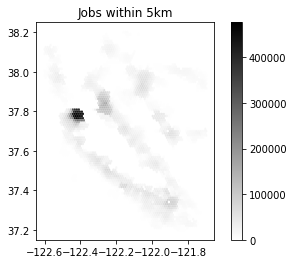

In [76]:
extent = (-121.7, -122.6, 37.2, 38.2)  # left right bottom top

data = job_access
values = data.jobs

fig, ax = plt.subplots()
ax.set_aspect(1.1)  # ratio of x to y
plt.title('Jobs within 5km')
hb = plt.hexbin(data.x, data.y, C=values, reduce_C_function=np.median, 
                extent=extent, mincnt=5, gridsize=80, linewidths=0, cmap='binary')
fig.colorbar(hb)

In [44]:
# NEW - get locations of businesses

ids = jobs.building_id.unique()  # building id's that contain a business
print(len(ids))
print(ids[:3])

108131
[ 1763004.   374976.   335036.]


In [45]:
businesses = merged.loc[ids, ['x','y']]
print(len(businesses))
print(businesses.head(3))

108131
                         x          y
b'building_id'                       
1763004.0      -122.398897  37.792143
374976.0       -122.398099  37.792949
335036.0       -122.397348  37.794053


In [ ]:
# Redo with building types

Key for `building_type_id` and `building_type`

````
01 - HS - single-family
02 - HT - townhomes
03 - HM - multi-family
04 - OF - office
05 - HO - hotel
06 - SC - school
07 - IL - light industrial
08 - IW - warehouse industrial
09 - IH - heavy industrial
10 - RS - retail strip
11 - RB - retail big box
12 - MR - mixed use residential focused
13 - MT - mixed use retail focused
14 - ME - mixed use employment focused
15 - PA - parking
16 - PA2 - parking
````

In [16]:
# Use retail buildings as a rough proxy for accessibility to shopping

retail = merged.loc[merged.building_type_id.isin([10,11,12,13])].copy()
print(len(retail))

38792


In [17]:
# Link to panadana network
retail['node_ids'] = net.get_node_ids(retail.x, retail.y)
net.set(retail.node_ids, name='retail')

In [18]:
%%time
access = net.aggregate(1000, type='sum', decay='flat', name='retail').rename('retail').to_frame()
access = pd.merge(access, nodes, how='left', left_index=True, right_index=True)
print(len(access))
print(access.head())

226060
    retail           x          y
8     17.0 -121.546785  36.997092
9     18.0 -121.548863  36.999641
10    27.0 -121.550719  37.002132
11    27.0 -121.550795  37.004075
12    27.0 -121.550784  37.004226
CPU times: user 2.04 s, sys: 9.27 s, total: 11.3 s
Wall time: 25.9 s


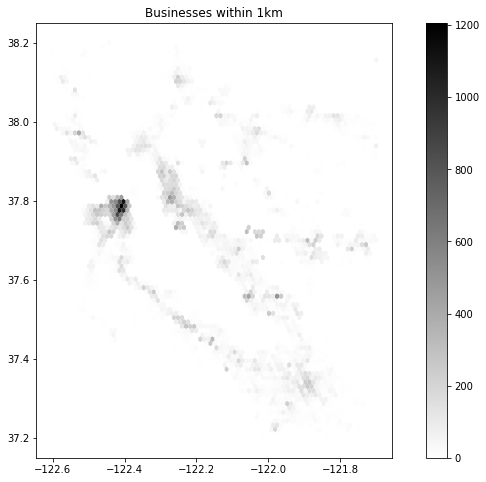

In [55]:
extent = (-121.7, -122.6, 37.2, 38.2)  # left right bottom top

data = access
values = data.businesses

fig, ax = plt.subplots()
ax.set_aspect(1.1)  # ratio of x to y
plt.title('Businesses within 1km')
hb = plt.hexbin(data.x, data.y, C=values, reduce_C_function=np.median, 
                extent=extent, mincnt=1, gridsize=80, linewidths=0, cmap='binary')
fig.colorbar(hb)

In [56]:
%%time
access = net.aggregate(2000, type='sum', decay='flat', name='businesses').rename('businesses').to_frame()
access = pd.merge(access, nodes, how='left', left_index=True, right_index=True)
print(len(access))
print(access.head())

226060
    businesses           x          y
8         60.0 -121.546785  36.997092
9         62.0 -121.548863  36.999641
10        63.0 -121.550719  37.002132
11        69.0 -121.550795  37.004075
12        69.0 -121.550784  37.004226
CPU times: user 973 ms, sys: 12 ms, total: 985 ms
Wall time: 978 ms


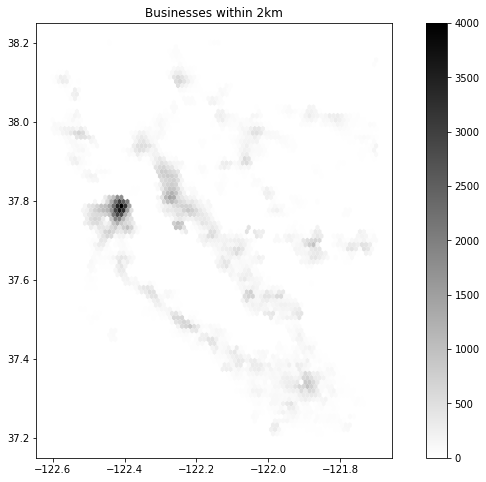

In [57]:
extent = (-121.7, -122.6, 37.2, 38.2)  # left right bottom top

data = access
values = data.businesses

fig, ax = plt.subplots()
ax.set_aspect(1.1)  # ratio of x to y
plt.title('Businesses within 2km')
hb = plt.hexbin(data.x, data.y, C=values, reduce_C_function=np.median, 
                extent=extent, mincnt=1, gridsize=80, linewidths=0, cmap='binary')
fig.colorbar(hb)

In [19]:
%%time
access = net.aggregate(5000, type='sum', decay='flat', name='retail').rename('retail').to_frame()
access = pd.merge(access, nodes, how='left', left_index=True, right_index=True)
print(len(access))
print(access.head())

226060
    retail           x          y
8    291.0 -121.546785  36.997092
9    299.0 -121.548863  36.999641
10   317.0 -121.550719  37.002132
11   324.0 -121.550795  37.004075
12   326.0 -121.550784  37.004226
CPU times: user 2.36 s, sys: 40.8 ms, total: 2.4 s
Wall time: 2.38 s


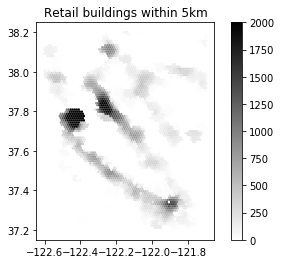

In [24]:
extent = (-121.7, -122.6, 37.2, 38.2)  # left right bottom top

data = access
values = data.retail

def capped_median(C):
    return min(np.median(C), 2000)

fig, ax = plt.subplots()
ax.set_aspect(1.1)  # ratio of x to y
plt.title('Retail buildings within 5km')
hb = plt.hexbin(data.x, data.y, C=values, reduce_C_function=capped_median, 
                extent=extent, mincnt=1, gridsize=80, linewidths=0, cmap='binary')
fig.colorbar(hb)

In [60]:
%%time
access = net.aggregate(10000, type='sum', decay='flat', name='businesses').rename('businesses').to_frame()
access = pd.merge(access, nodes, how='left', left_index=True, right_index=True)
print(len(access))
print(access.head())

226060
    businesses           x          y
8        767.0 -121.546785  36.997092
9        775.0 -121.548863  36.999641
10       777.0 -121.550719  37.002132
11       781.0 -121.550795  37.004075
12       781.0 -121.550784  37.004226
CPU times: user 1min 37s, sys: 658 ms, total: 1min 38s
Wall time: 1min 37s


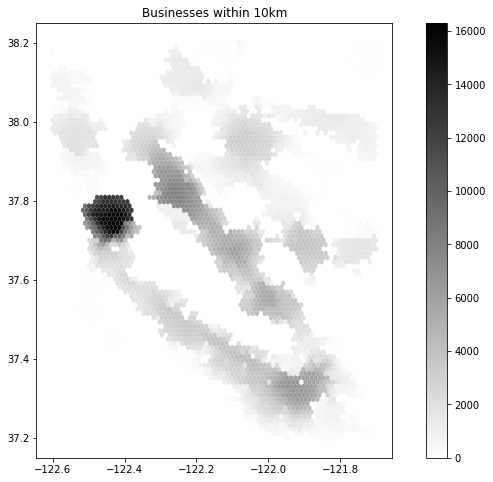

In [61]:
extent = (-121.7, -122.6, 37.2, 38.2)  # left right bottom top

data = access
values = data.businesses

fig, ax = plt.subplots()
ax.set_aspect(1.1)  # ratio of x to y
plt.title('Businesses within 10km')
hb = plt.hexbin(data.x, data.y, C=values, reduce_C_function=np.median, 
                extent=extent, mincnt=1, gridsize=80, linewidths=0, cmap='binary')
fig.colorbar(hb)

## Load rental data

In [31]:
rentals = pd.read_csv('/Users/smmaurer/Dropbox/Data/UAL/Craigslist/sfbay_craigslist.csv')
print(len(rentals))
print(rentals.head(3))

73644
               neighborhood   price  bedrooms        date  sqft_per_unit  \
0  twin peaks / diamond hts  4500.0       2.0  2014-05-11         1200.0   
1                 sunnyvale  2650.0       2.0  2014-05-11         1040.0   
2                 glen park  3100.0       2.0  2014-05-11         1000.0   

          lon        lat  price_per_sqft  
0 -122.438300  37.745000        3.750000  
1 -122.008131  37.353699        2.548077  
2 -122.439743  37.731584        3.100000  


In [32]:
rentals.price_per_sqft.describe()

count    73644.000000
mean         4.697802
std        183.768413
min          0.000154
25%          2.055256
50%          2.587519
75%          3.135714
max      31145.389277
Name: price_per_sqft, dtype: float64

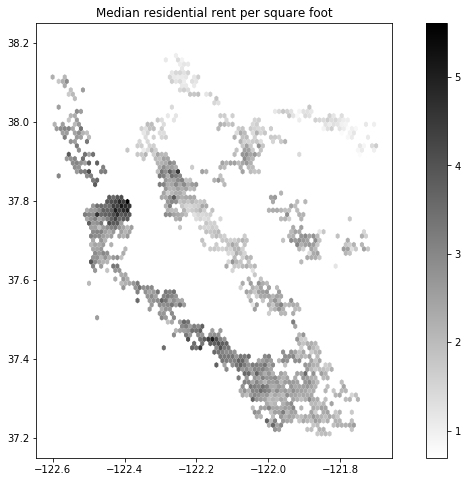

In [12]:
extent = (-121.7, -122.6, 37.2, 38.2)  # left right bottom top

data = rentals.loc[rentals.price_per_sqft < 10]
values = data.price_per_sqft

fig, ax = plt.subplots()
ax.set_aspect(1.1)  # ratio of x to y
plt.title('Median residential rent per square foot')
hb = plt.hexbin(data.lon, data.lat, C=values, reduce_C_function=np.median, 
                extent=extent, mincnt=5, gridsize=80, linewidths=0, cmap='binary')
fig.colorbar(hb)

In [28]:
# Census state outlines
path = '/Users/smmaurer/Dropbox/Data/Census shapefiles/cb_2016_us_state_500k/cb_2016_us_state_500k.shp'
states = gpd.read_file(path)
print(len(states))
print(states.columns)

56
Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')


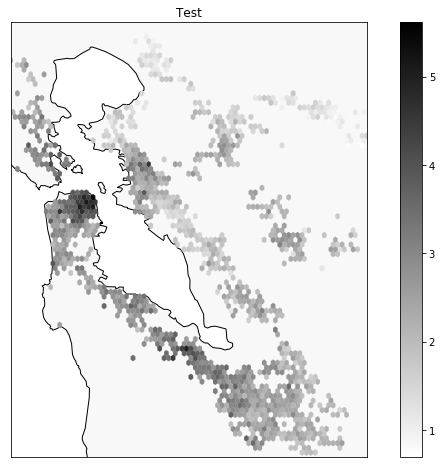

In [24]:
fig, ax = plt.subplots()
ax.set_aspect(1.1)
ax.set_xlim((-122.6, -121.7))
ax.set_ylim((37.2, 38.2))
plt.title("Test")

states.plot(ax=ax, color=(0.95,0.95,0.95), edgecolor='black', zorder=1)

data = rentals.loc[rentals.price_per_sqft < 10]
values = data.price_per_sqft
hb = plt.hexbin(data.lon, data.lat, C=values, reduce_C_function=np.median, 
                extent=extent, mincnt=5, gridsize=80, linewidths=0, cmap='binary', zorder=2)
fig.colorbar(hb)

ax.set_xticks([])
ax.set_xticklabels('')
ax.set_yticks([])
ax.set_yticklabels('')
plt.show()

In [25]:
%%time
access = net.aggregate(5000, type='sum', decay='flat', name='retail').rename('retail').to_frame()
access = pd.merge(access, nodes, how='left', left_index=True, right_index=True)
print(len(access))
print(access.head())

226060
    retail           x          y
8    291.0 -121.546785  36.997092
9    299.0 -121.548863  36.999641
10   317.0 -121.550719  37.002132
11   324.0 -121.550795  37.004075
12   326.0 -121.550784  37.004226
CPU times: user 2.33 s, sys: 41.8 ms, total: 2.37 s
Wall time: 2.35 s


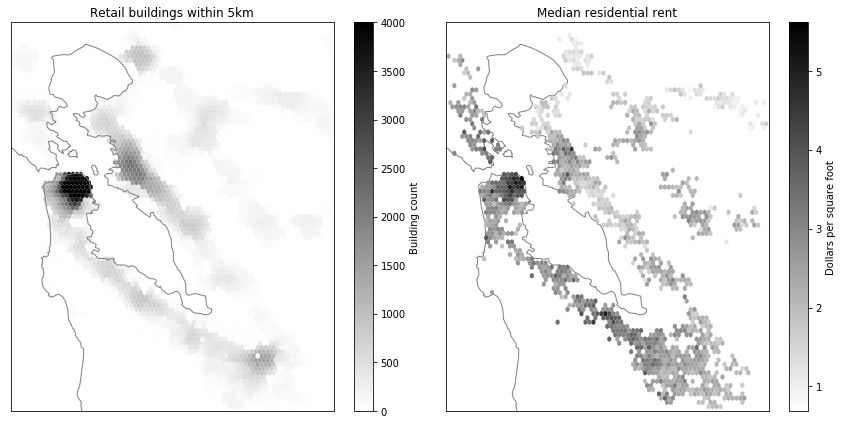

In [35]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12,6))

#####################
ax = axs[0]
ax.set_aspect(1.1)
ax.set_xlim((-122.6, -121.7))
ax.set_ylim((37.2, 38.2))
ax.set_title("Retail buildings within 5km")

states.plot(ax=ax, color='none', edgecolor='grey', zorder=2)

data = access
values = data.retail

def capped_median(C):
    return min(np.median(C), 4000)

hb = ax.hexbin(data.x, data.y, C=values, reduce_C_function=capped_median, 
                extent=extent, mincnt=1, gridsize=80, linewidths=0, cmap='binary', zorder=1)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Building count')

ax.set_xticks([])
ax.set_xticklabels('')
ax.set_yticks([])
ax.set_yticklabels('')

#####################
ax = axs[1]
ax.set_aspect(1.1)
ax.set_xlim((-122.6, -121.7))
ax.set_ylim((37.2, 38.2))
ax.set_title("Median residential rent")

states.plot(ax=ax, color='white', edgecolor='grey', zorder=1)

data = rentals.loc[rentals.price_per_sqft < 10]
values = data.price_per_sqft
hb = ax.hexbin(data.lon, data.lat, C=values, reduce_C_function=np.median, 
                extent=extent, mincnt=5, gridsize=80, linewidths=0, cmap='binary', zorder=2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Dollars per square foot')

ax.set_xticks([])
ax.set_xticklabels('')
ax.set_yticks([])
ax.set_yticklabels('')

#####################
plt.tight_layout()
plt.show()

In [36]:
fig.savefig('../output/map-price-and-access-v2.pdf')

Resources
- https://github.com/UDST/pandana/blob/master/docs/tutorial.rst